In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import butter, sosfilt, stft, welch
from scipy.optimize import curve_fit

In [2]:
def get_psd(data, channel=1):
    fs = int(np.ceil(1 / (data[0, 1] - data[0, 0])))
    nperseg = fs / 10
    
    ff, pp = welch(data[channel], fs=fs, nperseg=nperseg)
    return ff, pp

def peak_amplitude_stft(tod, fs, nperseg, driving_freq):
    
    ff, tt, Zxx = stft(tod, fs=fs, nperseg=nperseg)
    sig = np.abs(Zxx)
    # f = np.where(ff==driving_freq)[0][0]
    f = np.argmin(np.abs(ff - driving_freq))

    # time, peak amplitude^2, sample frequency, sftp
    return tt, sig[f], ff, Zxx[f]

In [3]:
def get_filtered_signal(data, f_hp, f_lp, order=8):
    fs = int(np.ceil(1 / (data[0, 1] - data[0, 0]))) * 1000 # Sampling rate in Hz
    
    sos_hp = butter(order, f_hp, 'hp', fs=fs, output='sos')
    sos_lp = butter(order, f_lp, 'lp', fs=fs, output='sos')
    
    filtered = sosfilt(sos_hp, data[1])
    filtered_filtered = sosfilt(sos_lp, filtered)
    
    return filtered_filtered

In [27]:
def plot_peak_amp(data, drive_freq, filtered=True):
    fs = int(np.ceil(1 / (data[0, 1] - data[0, 0])))
#     nperseg = fs / 5
    nperseg = fs / 5
    
    if filtered:
        f_hp = 1000
        sos_hp = butter(4, f_hp, 'hp', fs=fs, output='sos')
        dd = sosfilt(sos_hp, data[1])
    else:
        dd = data[1]

    tt, sig, ff, Zxx = peak_amplitude_stft(dd, fs, nperseg, drive_freq)
    
    fig, ax = plt.subplots(figsize = (20, 6))
    ax.grid()
    ax.plot(tt, sig, 'r.', markersize=15)

    ax.set_xlabel('Time (s)', fontsize=18)
    ax.set_ylabel(f'Peak amplitude@{int(drive_freq/1000)} kHz (V)', fontsize=18)
    ax.set_title('1 mbar, driving field = 10 V peak to peak', fontsize=20)
    
    return fig, ax

## Determine the charge state of the nanosphere

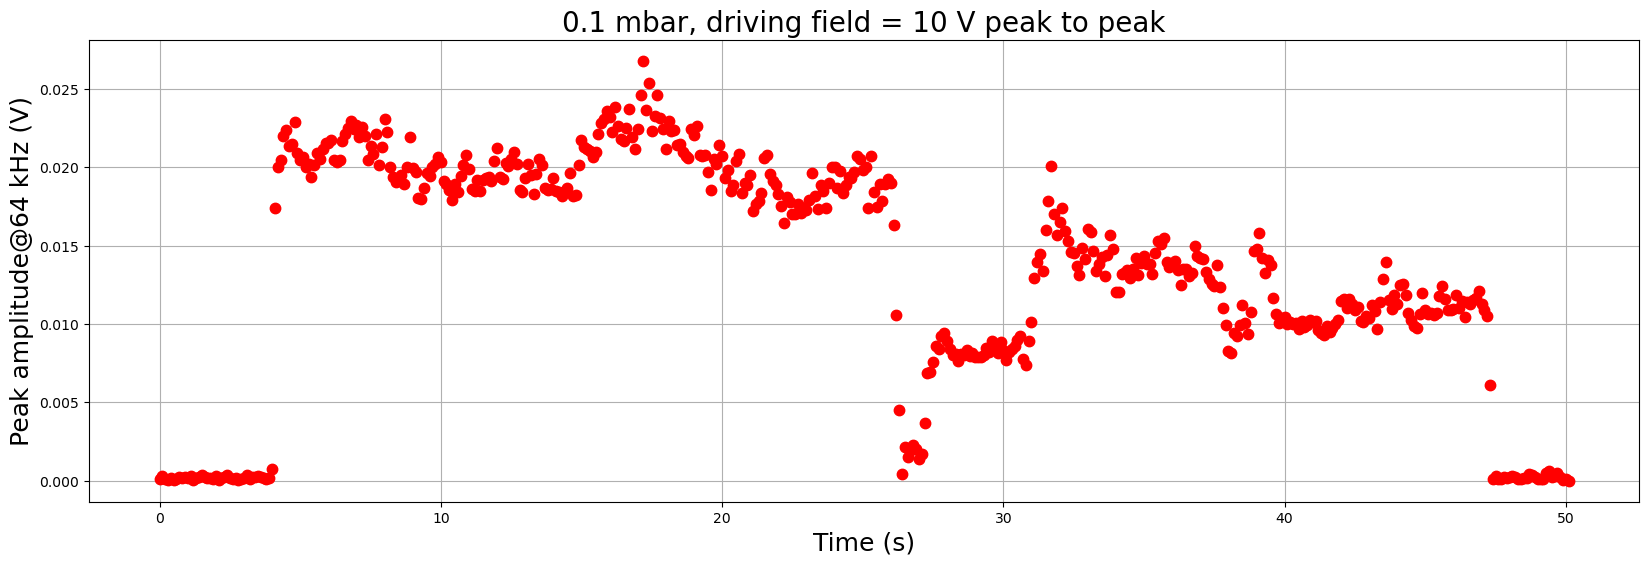

In [6]:
data_file = r"D:\Experiment\Charging\20231122\charging_64khz_50s_0.csv"
data = np.genfromtxt(data_file, delimiter=',', skip_header=3).T

fig, ax = plot_peak_amp(data, 64000, False)

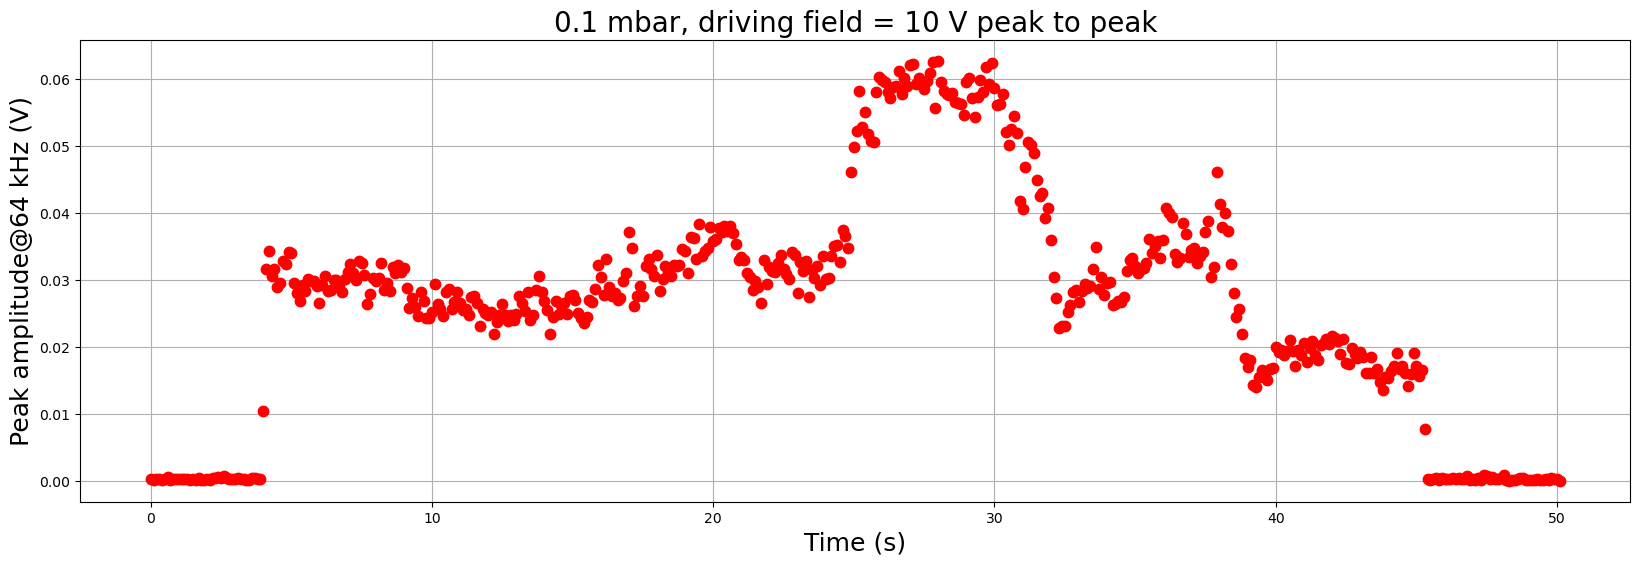

In [7]:
data_file = r"D:\Experiment\Charging\20231122\charging_64khz_50s_1.csv"
data = np.genfromtxt(data_file, delimiter=',', skip_header=3).T

fig, ax = plot_peak_amp(data, 64000, False)

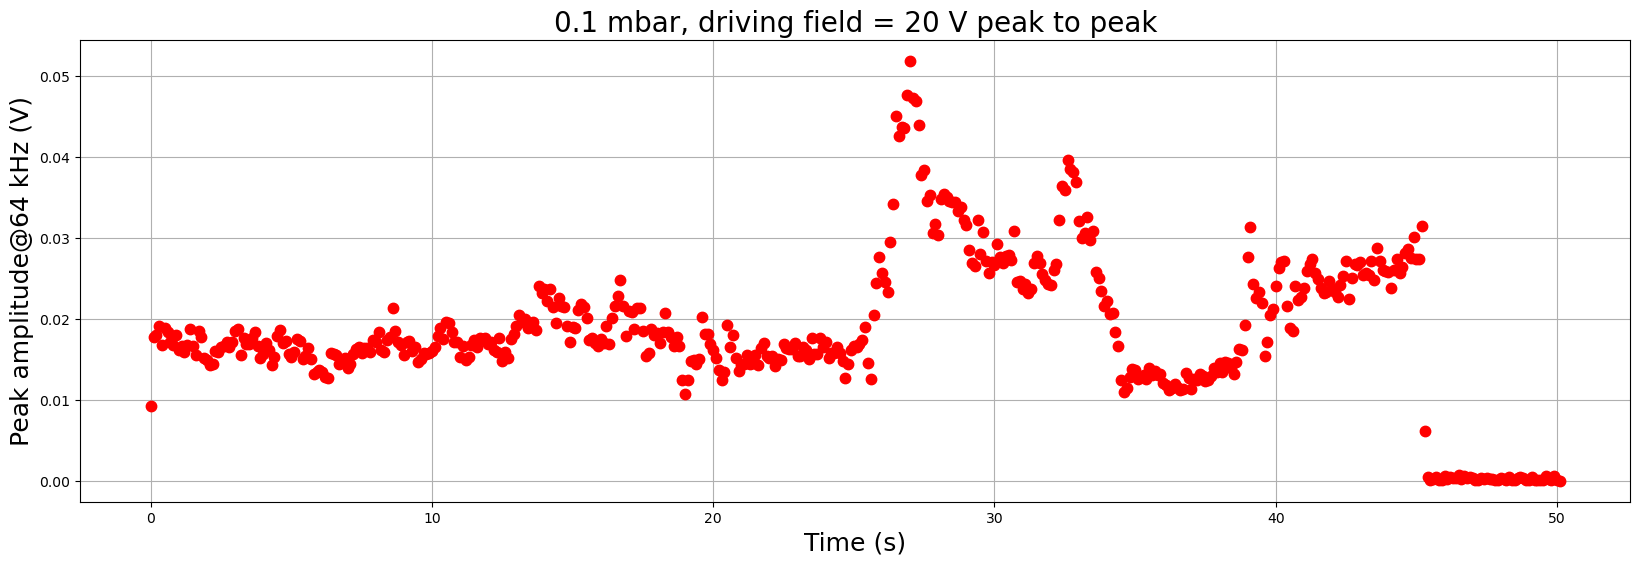

In [9]:
data_file = r"D:\Experiment\Charging\20231122\charging_64khz_50s_2.csv"
data = np.genfromtxt(data_file, delimiter=',', skip_header=3).T

fig, ax = plot_peak_amp(data, 64000, False)

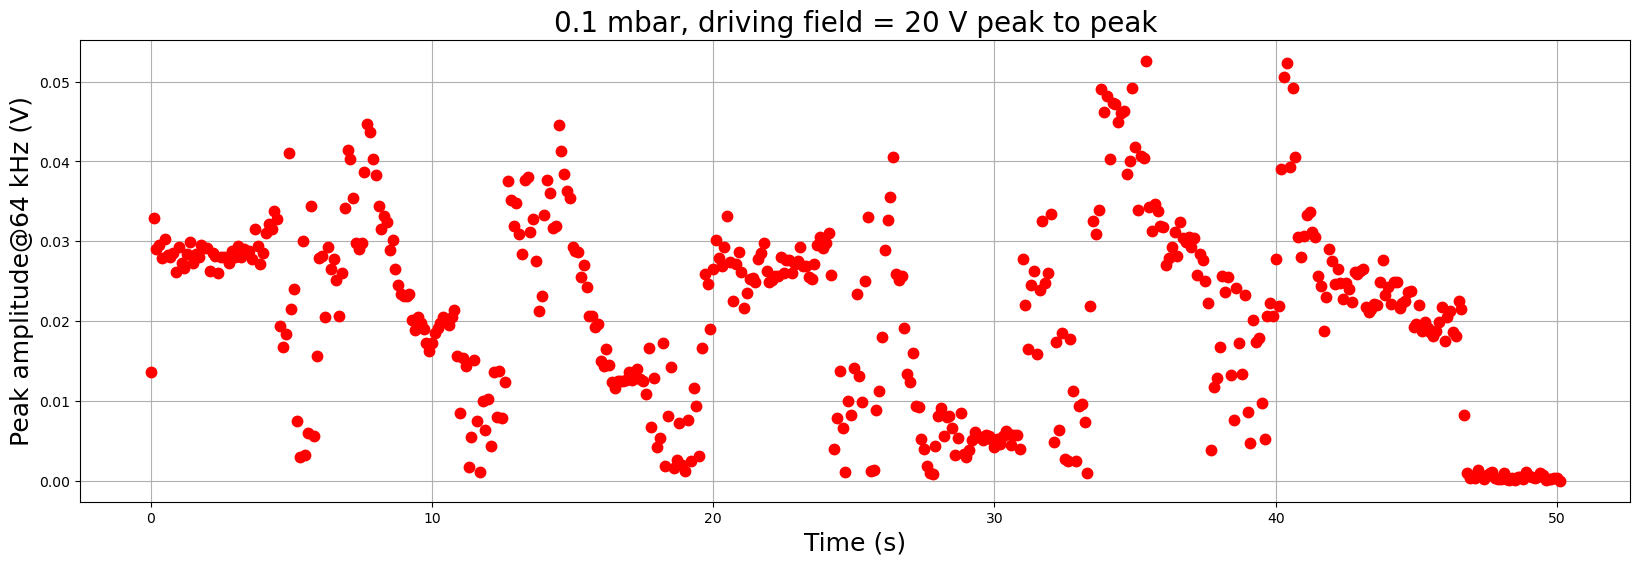

In [10]:
data_file = r"D:\Experiment\Charging\20231122\charging_64khz_50s_3.csv"
data = np.genfromtxt(data_file, delimiter=',', skip_header=3).T

fig, ax = plot_peak_amp(data, 64000, False)

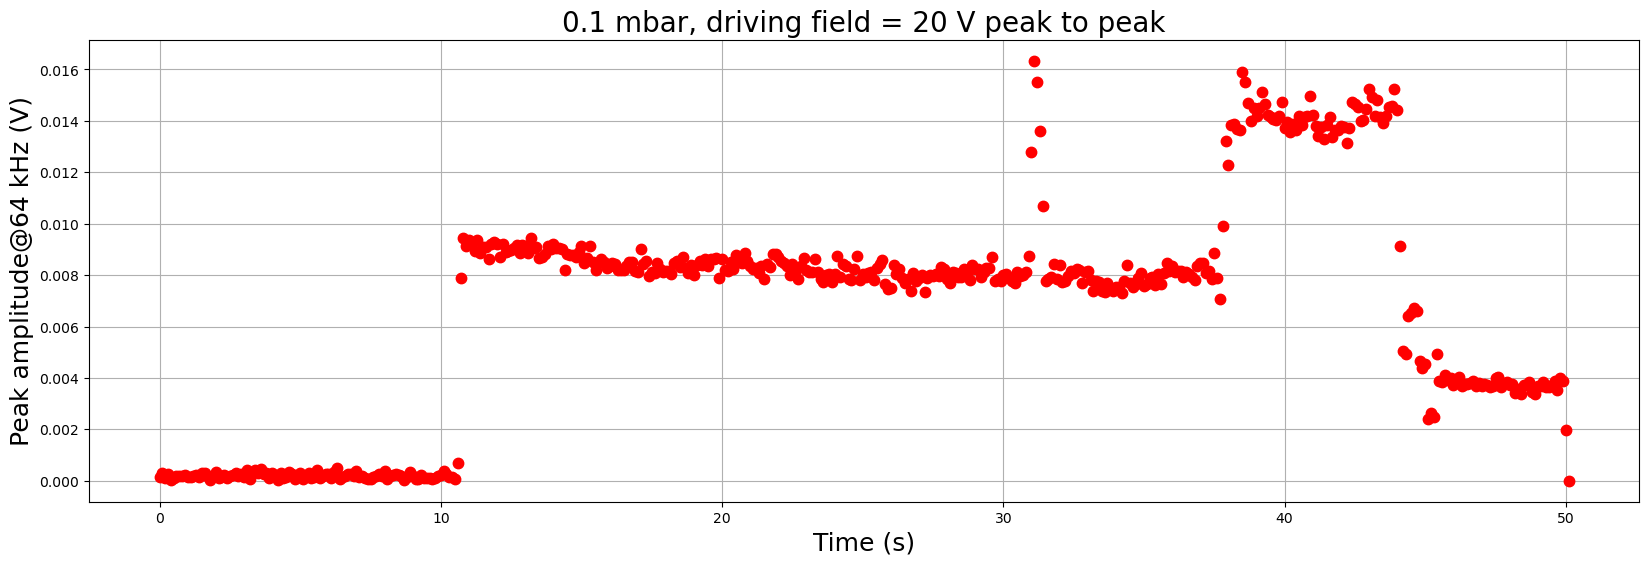

In [11]:
data_file = r"D:\Experiment\Charging\20231122\charging_64khz_50s_4.csv"
data = np.genfromtxt(data_file, delimiter=',', skip_header=3).T

fig, ax = plot_peak_amp(data, 64000, False)

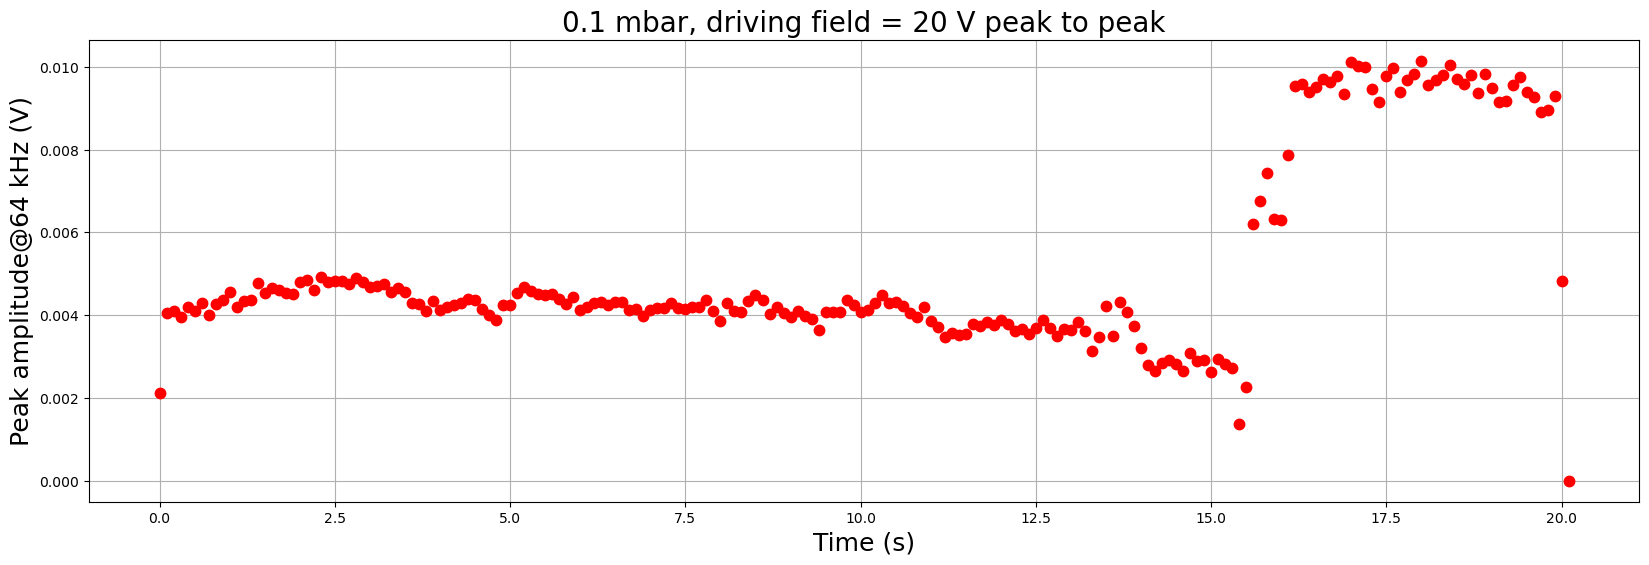

In [12]:
data_file = r"D:\Experiment\Charging\20231122\charging_64khz_20s_5.csv"
data = np.genfromtxt(data_file, delimiter=',', skip_header=3).T

fig, ax = plot_peak_amp(data, 64000, False)

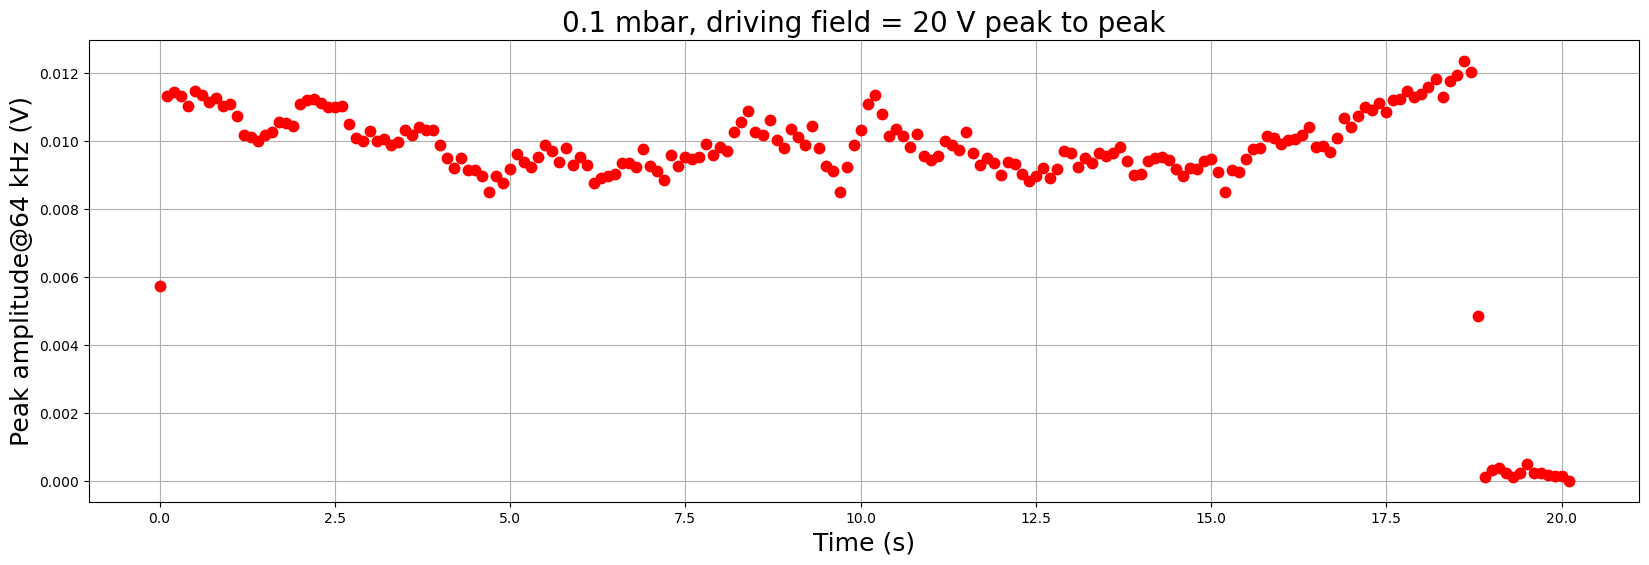

In [14]:
data_file = r"D:\Experiment\Charging\20231122\charging_64khz_20s_6.csv"
data = np.genfromtxt(data_file, delimiter=',', skip_header=3).T

fig, ax = plot_peak_amp(data, 64000, False)

Looks like there are 2e charge on the sphere.

In [15]:
def peak_func(x, amp, omega_0, gamma):
    """A Lorentzian line shape"""
    return amp * gamma / ( ( omega_0**2 - x**2)**2 + gamma**2 * x**2 )

def fit_peak(x, y, peak_func, p0=None):
    popt, pcov = curve_fit(peak_func, x, y, p0=p0)
    
    # Return central frequency and gamma
    return popt, x, peak_func(x, *popt)

In [17]:
data_file = r"D:\Experiment\Calibration\20231122\noefield_5s_1_1mbar.csv"
data = np.genfromtxt(data_file, delimiter=',', skip_header=3).T

ff, pp = get_psd(data)

Amplitude: 3694406880.388706, central frequency: 60070.67578649386 Hz, gamma: 1967.9406312010415 Hz


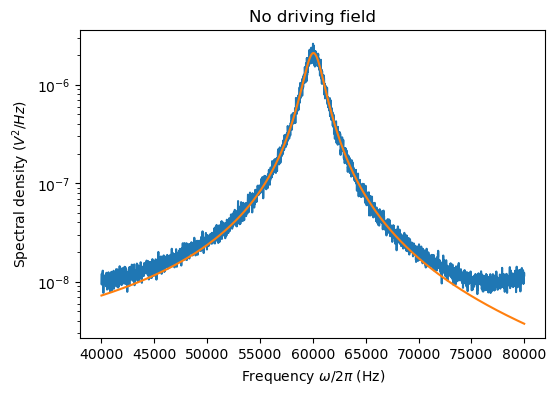

In [18]:
lb, ub = 4000, 8000

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(ff[lb:ub], pp[lb:ub])

# Fit with a Lorentzian and plot
popt, omega_fit, p_fit = fit_peak(ff[lb:ub]*2*np.pi, pp[lb:ub], peak_func, p0=[3e8, 60000*2*np.pi, 8000])
ax.plot(omega_fit/(2*np.pi), p_fit)

amp, omega0, gamma = popt[0], popt[1], popt[2]
print(f'Amplitude: {amp}, central frequency: {omega0/(2*np.pi)} Hz, gamma: {gamma/(2*np.pi)} Hz')

ax.set_title('No driving field')
ax.set_xlabel('Frequency $\omega / 2 \pi$ (Hz)')
ax.set_ylabel('Spectral density ($V^2 / Hz$)')

ax.set_yscale('log')

In [19]:
T   = 300  # K
kb  = 1.38e-23

# Use this value after ethanol is gone
rho = 2200 # kg/m^3
r   = 167e-9 / 2
m   = rho * (4 * np.pi / 3) * r**3 

# Again need to take care of 2 pi normalization
# because the formula assume integrating over `omega`, not `f`
v2 = 0.5 * np.pi/(gamma * omega0**2) * amp * gamma / (2 * np.pi)

# Calibration factor converting <V^2> to (x^2)
c_cal_square = (v2 * m * omega0**2) / (kb * T)
print(fr'Calibration factor square $c^2$: {c_cal_square}')

Calibration factor square $c^2$: 1196892397814.357


In [20]:
data_file = r"D:\Experiment\Calibration\20231122\nohv_64khz_20vp2p_5s_0.csv"
data = np.genfromtxt(data_file, delimiter=',', skip_header=3).T

ff, pp = get_psd(data)

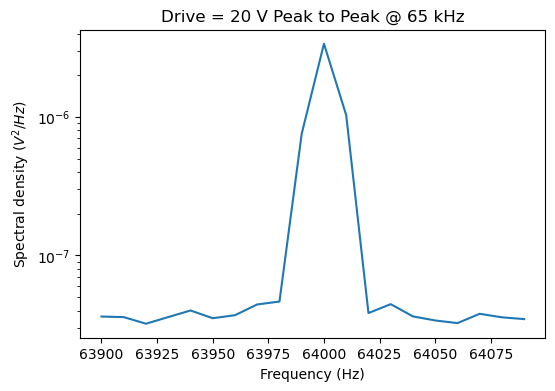

In [21]:
lb, ub = 6390, 6410
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(ff[lb:ub], pp[lb:ub])

ax.set_title('Drive = 20 V Peak to Peak @ 65 kHz')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Spectral density ($V^2 / Hz$)')

ax.set_yscale('log')

In [22]:
all_idx = np.arange(lb, ub, 1)
excluding_peak = np.logical_or(all_idx < 6397, all_idx > 6403)

area_all = np.trapz(pp[all_idx], ff[all_idx]*2*np.pi)
area_excluding_peak = np.trapz( pp[all_idx[excluding_peak]], ff[all_idx[excluding_peak]]*2*np.pi )

# Excluding background contribution (which is very small)
# Take care of 2 pi normalization after numerical integration
# because we integrated over omega here
v2_drive = (area_all - area_excluding_peak) / (2 * np.pi)

In [25]:
omega_drive = 64000 * 2 * np.pi

x2_drive = v2_drive / c_cal_square
f_amp_squared = x2_drive * 2 * m**2 * ( (omega0**2 - omega_drive**2)**2 + gamma**2 * omega_drive**2)

charge = np.sqrt(f_amp_squared) / (1.6e-19 * 120 * 10)
print(f'Charge on the sphere derived through a driving E field: +/- {charge:.2f} e')

Charge on the sphere derived through a driving E field: +/- 5.12 e


Doesn't agree with our guess...try again.

Below are charing at 1.1 mbar (ignore the figure title)

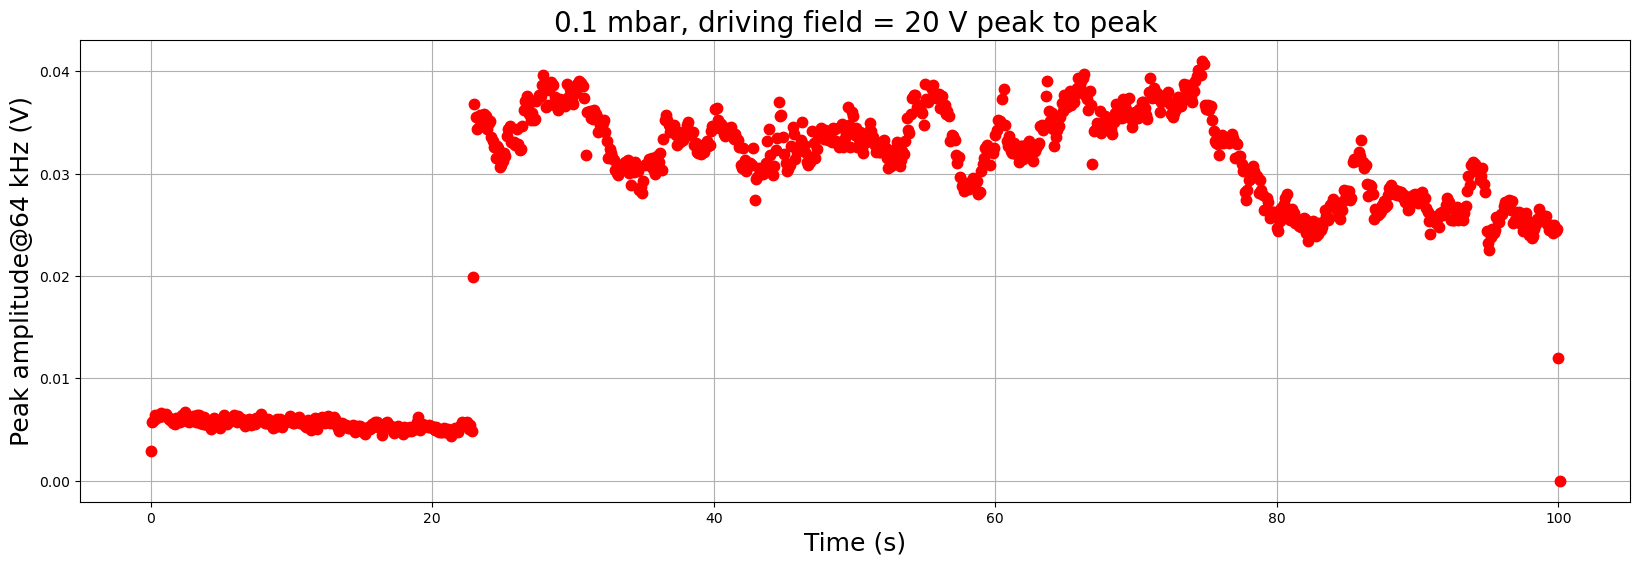

In [26]:
data_file = r"D:\Experiment\Charging\20231122\charging_64khz_100s_7.csv"
data = np.genfromtxt(data_file, delimiter=',', skip_header=3).T

fig, ax = plot_peak_amp(data, 64000, False)

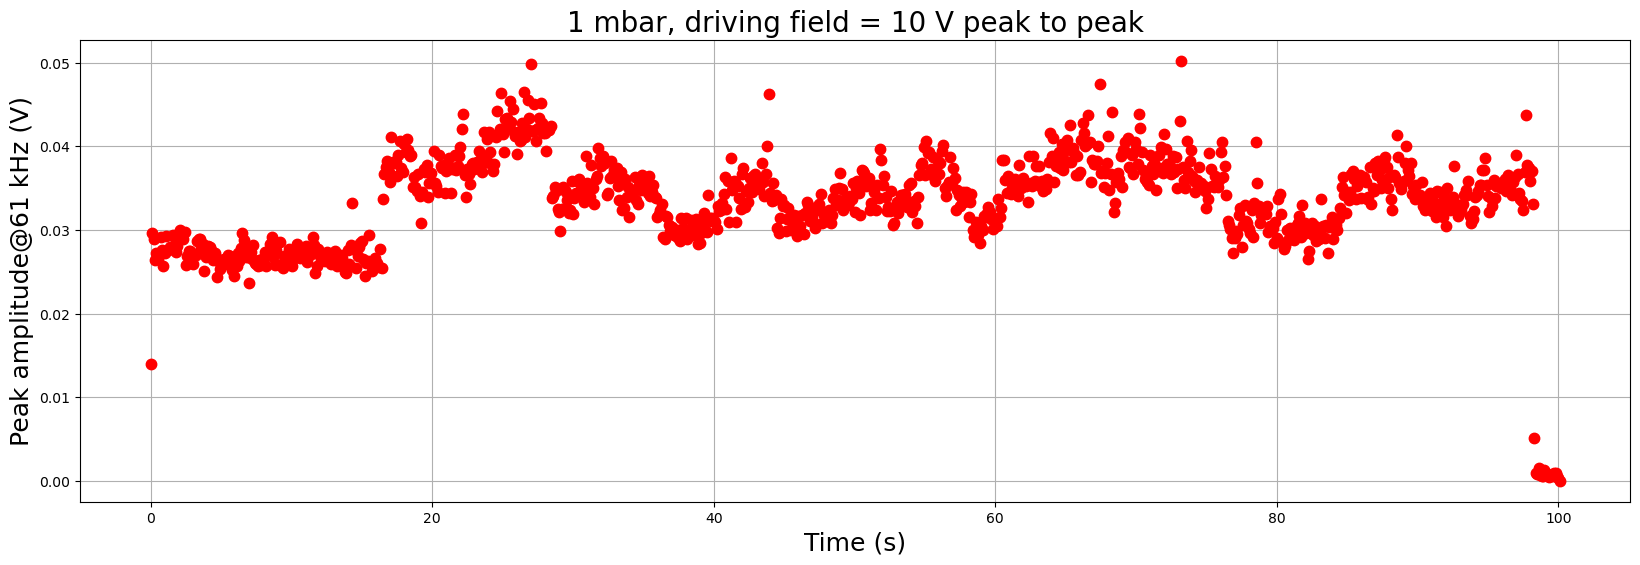

In [29]:
# data_file = r"D:\Experiment\Charging\20231122\charging_64khz_100s_8.csv"
# data = np.genfromtxt(data_file, delimiter=',', skip_header=3).T

fig, ax = plot_peak_amp(data, 61000, False)